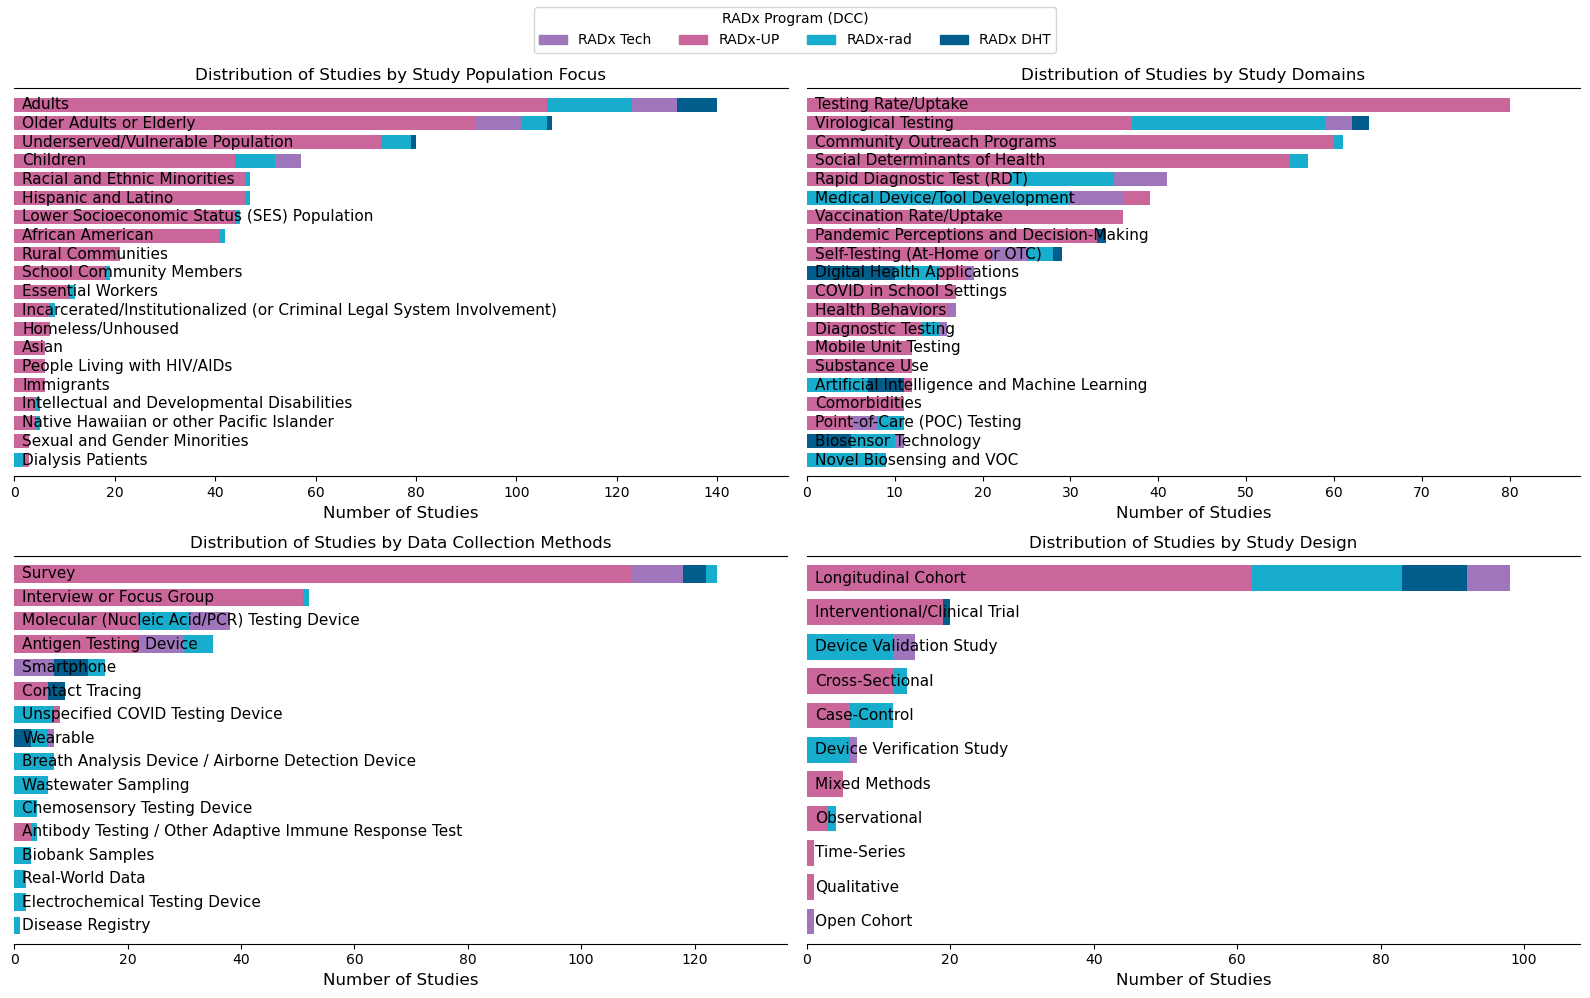

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For custom legend

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------

def load_and_preprocess_data(file_path):
    """
    Load data from the CSV file and preprocess it by splitting specified columns.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    data = pd.read_csv(file_path, encoding="latin1")
    columns_to_split = ["Study Population Focus", "Study Domain", "Data Collection Method"]

    for column in columns_to_split:
        data[column] = data[column].str.split("; ")

    return data

# -------------------------------
# 2. Prepare Data for Visualization
# -------------------------------

def get_top_categories(data, column_name, top_n=20):
    """
    Get the top N categories based on frequency in the specified column.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column to analyze.
        top_n (int): Number of top categories to return.

    Returns:
        pd.Index: Index of the top N categories.
    """
    exploded_data = data.explode(column_name)
    top_categories = exploded_data[column_name].value_counts().head(top_n).index
    return top_categories

def prepare_stacked_data(data, column_name, top_categories):
    """
    Prepare a DataFrame for stacked bar plotting.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column to analyze.
        top_categories (pd.Index): The top categories to include.

    Returns:
        pd.DataFrame: Prepared DataFrame for plotting.
    """
    exploded_data = data.explode(column_name)
    filtered_data = exploded_data[exploded_data[column_name].isin(top_categories)]
    grouped_data = filtered_data.groupby([column_name, "RADx Data Program"]).size().unstack(fill_value=0)
    return grouped_data

def sort_stacked_data(data):
    """
    Sort the data for better visualization.

    Args:
        data (pd.DataFrame): The DataFrame to sort.

    Returns:
        pd.DataFrame: Sorted DataFrame.
    """
    data = data.loc[data.sum(axis=1).sort_values(ascending=True).index]
    return data

# -------------------------------
# 3. Plotting Function
# -------------------------------

def plot_stacked_bars_horizontal_ordered(data_list, titles, xlabel, colors, output_file):
    """
    Plot horizontal stacked bar charts with labels vertically centered with y-tick marks.

    Args:
        data_list (list): List of DataFrames to plot.
        titles (list): Titles for each subplot.
        xlabel (str): Label for the x-axis.
        colors (dict): Dictionary mapping RADx Programs to colors.
        output_file (str): File name to save the plot.
    """
    import matplotlib.transforms as mtransforms

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, data in enumerate(data_list):
        ax = axes[i]

        # Define the space between bars and padding
        total_bars = len(data)
        bar_height = 0.6  # Adjust bar height as needed
        bar_spacing = 0.2  # Adjust spacing as needed
        padding = 0.025  # Padding as a fraction of the total chart height

        # Adjust y_positions to add spacing
        y_positions = [index * (bar_height + bar_spacing) for index in range(total_bars)]
        y_labels = data.index

        # Calculate maximum value for x-axis limit
        max_value = data.sum(axis=1).max() * 1.1  # Add padding

        # Plot each bar individually
        for y_pos, (index, row) in zip(y_positions, data.iterrows()):
            # Sort counts in decreasing order
            row_sorted = row.sort_values(ascending=False)
            programs = row_sorted.index
            counts = row_sorted.values
            left = 0

            for program, count in zip(programs, counts):
                if count > 0:
                    ax.barh(
                        y=y_pos,
                        width=count,
                        left=left,
                        height=bar_height,
                        color=colors.get(program, "#333333"),
                        edgecolor='none'
                    )
                    left += count

        # Calculate total chart height
        total_chart_height = y_positions[-1] + bar_height

        # Calculate padding in data coordinates
        padding_value = total_chart_height * padding

        # Set y-axis limits with reduced padding
        ax.set_ylim(
            y_positions[0] - bar_height / 2 - padding_value,
            y_positions[-1] + bar_height / 2 + padding_value
        )
        ax.set_yticks(y_positions)
        ax.set_yticklabels([])  # Hide default y-tick labels
        ax.set_xlim(0, max_value)

        # Add category labels next to the bars, adjusting vertical alignment
        for y_pos, label in zip(y_positions, y_labels):
            # Create text object with initial position
            text_obj = ax.text(
                max_value * 0.01, y_pos, label,
                ha='left', va='center', fontsize=11, linespacing=1.3, color="black"
            )

            # Get the height of the text in data coordinates
            renderer = fig.canvas.get_renderer()
            bbox = text_obj.get_window_extent(renderer=renderer)
            inv = ax.transData.inverted()
            bbox_data = inv.transform_bbox(bbox)
            text_height = bbox_data.height

            # Adjust y-position to center the text vertically if needed
            # Uncomment the following line if labels are not vertically centered
            # text_obj.set_position((max_value * 0.01, y_pos - text_height / 2 + bar_height / 2))

        ax.set_title(titles[i], fontsize=12)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel("")

        # Optionally adjust spines and ticks
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', length=0)  # Remove y-axis ticks

    # Create custom legend
    legend_handles = [mpatches.Patch(color=color, label=program) for program, color in colors.items()]
    fig.legend(handles=legend_handles, title="RADx Program (DCC)", loc='upper center', ncol=4, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the legend
    plt.savefig(output_file, format="png", dpi=300)
    plt.show()

# -------------------------------
# 4. Main Execution Flow
# -------------------------------

def main():
    # File path to the CSV data
    file_path = "StudyExplorerResults.csv"  # Replace with your actual file path

    # Load and preprocess data
    data = load_and_preprocess_data(file_path)

    # Define columns to analyze
    analysis_columns = [
        ("Study Population Focus", "Distribution of Studies by Study Population Focus"),
        ("Study Domain", "Distribution of Studies by Study Domains"),
        ("Data Collection Method", "Distribution of Studies by Data Collection Methods"),
        ("Study Design", "Distribution of Studies by Study Design"),
    ]

    # RADx Program colors
    radx_colors = {
        "RADx Tech": "#9f75bb",
        "RADx-UP": "#ca6699",
        "RADx-rad": "#18accd",
        "RADx DHT": "#005d8c",
    }

    # Prepare data and titles for plotting
    data_list = []
    titles = []
    for column_name, title in analysis_columns:
        if column_name != "Study Design":
            top_categories = get_top_categories(data, column_name)
            stacked_data = prepare_stacked_data(data, column_name, top_categories)
        else:
            # For 'Study Design', use the original grouping without top categories
            grouped_data = data.groupby([column_name, "RADx Data Program"]).size().unstack(fill_value=0)
            stacked_data = sort_stacked_data(grouped_data)

        sorted_data = sort_stacked_data(stacked_data)
        data_list.append(sorted_data)
        titles.append(title)

    xlabel = "Number of Studies"
    output_file = "horizontal_labels_in.png"

    # Plot all charts with horizontal bars and save to a file
    plot_stacked_bars_horizontal_ordered(
        data_list=data_list,
        titles=titles,
        xlabel=xlabel,
        colors=radx_colors,
        output_file=output_file
    )

# Run the main function
if __name__ == "__main__":
    main()
